In [1]:
!pip install opencv-python numpy matplotlib scikit-learn



--- Running SIFT Pipeline ---
SIFT Matches: 28 | Time: 0.479s | Mem: 15.551 MB

--- Running ORB Pipeline ---
ORB Matches: 50 | Time: 0.469s | Mem: 103.641 MB


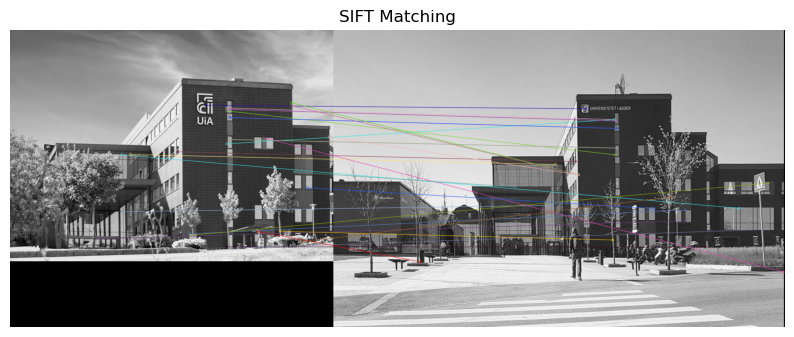

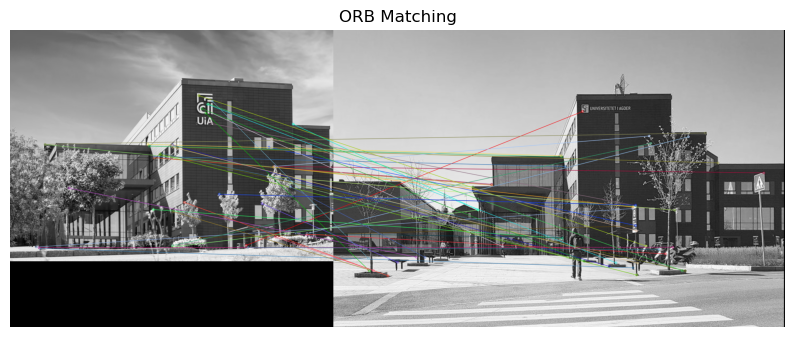


=== PERFORMANCE COMPARISON ===
SIFT: 28 good matches, 0.479s, 15.551 MB
ORB : 50 good matches, 0.469s, 103.641 MB

→ ORB is faster and uses fewer resources but slightly less accurate.


In [6]:
import cv2
import numpy as np
import time
import psutil
import os
import matplotlib.pyplot as plt

def resource_usage():
    process = psutil.Process(os.getpid())
    mem = process.memory_info().rss / 1024 ** 2  # in MB
    return mem

def sift_pipeline(img1, img2):
    start_time = time.time()
    start_mem = resource_usage()

    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    index_params = dict(algorithm=1, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)

    good = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good.append(m)

    elapsed_time = time.time() - start_time
    end_mem = resource_usage()

    return len(good), elapsed_time, (end_mem - start_mem), kp1, kp2, matches, good


def orb_pipeline(img1, img2):
    start_time = time.time()
    start_mem = resource_usage()

    orb = cv2.ORB_create()
    kp1, des1 = orb.detectAndCompute(img1, None)
    kp2, des2 = orb.detectAndCompute(img2, None)

    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)
    good = matches[:50]  # top 50

    elapsed_time = time.time() - start_time
    end_mem = resource_usage()

    return len(good), elapsed_time, (end_mem - start_mem), kp1, kp2, matches, good


def visualize_matches(img1, kp1, img2, kp2, good_matches, title):
    matched_image = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, flags=2)
    plt.figure(figsize=(10, 5))
    plt.imshow(cv2.cvtColor(matched_image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
    plt.show()


# === MAIN TEST SECTION ===
if __name__ == "__main__":
    # === Change these paths ===
    img1_path = "fingerprint1.png"   # Replace with your UiA or data_check image
    img2_path = "fingerprint2.png"

    img1 = cv2.imread(img1_path, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(img2_path, cv2.IMREAD_GRAYSCALE)

    print("\n--- Running SIFT Pipeline ---")
    sift_results = sift_pipeline(img1, img2)
    print(f"SIFT Matches: {sift_results[0]} | Time: {sift_results[1]:.3f}s | Mem: {sift_results[2]:.3f} MB")

    print("\n--- Running ORB Pipeline ---")
    orb_results = orb_pipeline(img1, img2)
    print(f"ORB Matches: {orb_results[0]} | Time: {orb_results[1]:.3f}s | Mem: {orb_results[2]:.3f} MB")

    # === Visualization ===
    visualize_matches(img1, sift_results[3], img2, sift_results[4], sift_results[6], "SIFT Matching")
    visualize_matches(img1, orb_results[3], img2, orb_results[4], orb_results[6], "ORB Matching")

    # === Comparison ===
    print("\n=== PERFORMANCE COMPARISON ===")
    print(f"SIFT: {sift_results[0]} good matches, {sift_results[1]:.3f}s, {sift_results[2]:.3f} MB")
    print(f"ORB : {orb_results[0]} good matches, {orb_results[1]:.3f}s, {orb_results[2]:.3f} MB")

    if sift_results[0] > orb_results[0]:
        print("\n→ SIFT is more accurate but slower.")
    else:
        print("\n→ ORB is faster and uses fewer resources but slightly less accurate.")
